<h1 style="background-color:#297a38;color:white;font-size:35px;font-family:verdana"><center>Rotten or Fresh Fruit Classification </center><h1>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2 as cv
import pickle
import joblib
from google.colab.patches import cv2_imshow
from pathlib import Path
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras

<h1 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Load ImageNet Base Model<h1>

In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Freeze Base Model<h2>

In [ ]:
# Freeze base model
base_model.trainable = False

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Add Layers to Model<h2>

In [ ]:
from keras.models import Model
from keras.layers import *

# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21,139,014
Trainable params: 6,424,326
Non-trai

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Compile Model<h2>

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Augment the Data<h2>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

transformation_ratio = 0.05

datagen = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.2,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=True,
                             preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Load Dataset<h2>

In [ ]:
# load and iterate training dataset
train_it = datagen.flow_from_directory("/content/gdrive/MyDrive/Fruit detection/Dataset/train",
                                       target_size=(224,224),
                                       color_mode='rgb',
                                       class_mode="categorical",
                                       batch_size=12,
                                       subset = "training")

# Validation Data
val_it = datagen.flow_from_directory("/content/gdrive/MyDrive/Fruit detection/Dataset/train",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=12,
                                     subset='validation')

# load and iterate test dataset
test_it = datagen.flow_from_directory("/content/gdrive/MyDrive/Fruit detection/Dataset/test",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      shuffle=False)

Found 8730 images belonging to 6 classes.
Found 2180 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Train the Model<h2>

In [ ]:
history = model.fit_generator(generator = train_it,
                              steps_per_epoch=train_it.samples/train_it.batch_size,
                              epochs=16,
                              validation_data=val_it,
                              validation_steps=test_it.samples/test_it.batch_size,
)

In [ ]:
# Save weight and model format
model.save('/content/gdrive/MyDrive/Fruit detection/fruit_classifier_vgg16_official_v2.h5')

#Load model

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("/content/gdrive/MyDrive/Fruit detection/Model weight/fruit_classifier_vgg16_ver2.h5")

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Evaluate the Model<h2>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.evaluate(test_it, steps=test_it.samples/test_it.batch_size)

84/84 [==============================] - 1643s 20s/step - loss: 0.5839 - accuracy: 0.8436


[0.5838600993156433, 0.8435878157615662]

#Predict

In [ ]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  return answer

In [ ]:
def predict_label(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class = answer.argmax(axis=-1)
  y = " ".join(str(x) for x in y_class)
  y = int(y)
  res = labels[y]
  return res

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_it)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (test_it.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]

85/85 [==============================] - 37s 437ms/step


In [ ]:
print(labels)

{0: 'freshapples', 1: 'freshbanana', 2: 'freshoranges', 3: 'rottenapples', 4: 'rottenbanana', 5: 'rottenoranges'}


In [ ]:
with open('/content/gdrive/MyDrive/Fruit detection/label_prediction_VGGFreeze_Model.txt','w') as f:
    f.writelines([f"{line}\n" for line in pred1])

In [ ]:
with open('/content/gdrive/MyDrive/Fruit detection/label_prediction_VGGFreeze_Model.txt') as f:
  prediction = f.read().splitlines()

In [ ]:
labels = (train_it.class_indices)
labels = dict((v,k) for k,v in labels.items())

1/1 [==============================] - 0s 18ms/step


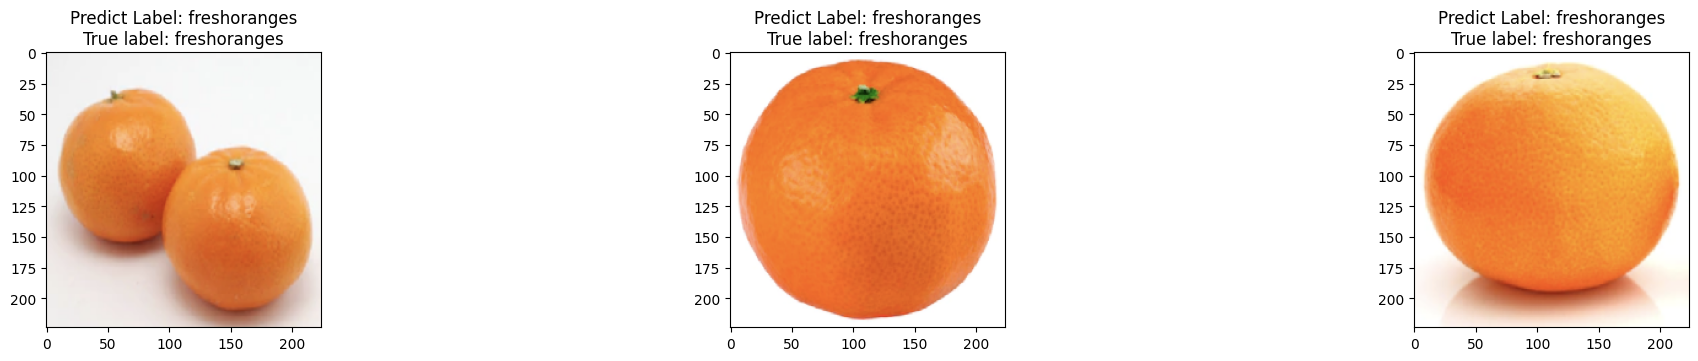

1/1 [==============================] - 0s 21ms/step


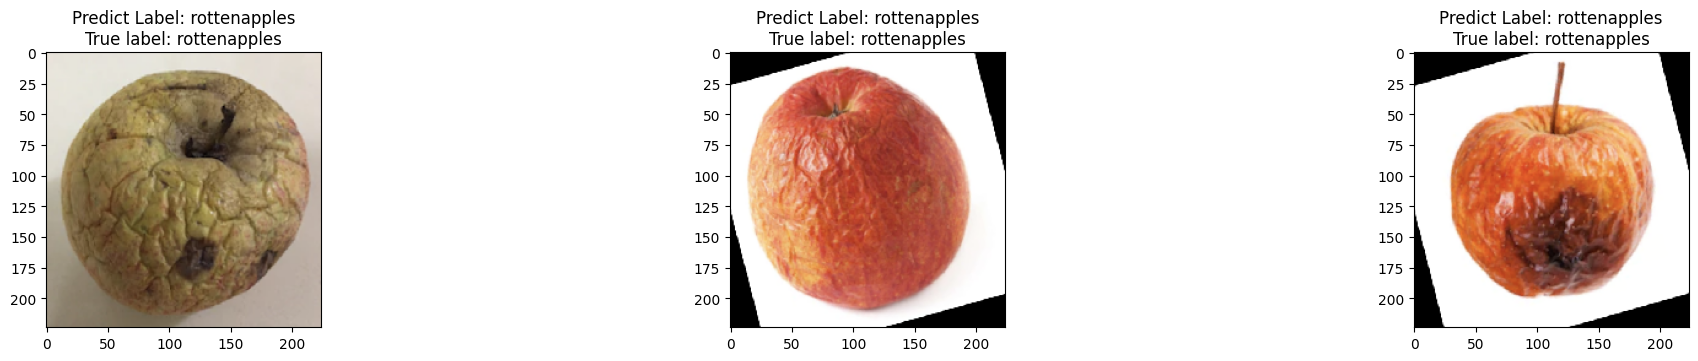

1/1 [==============================] - 0s 19ms/step


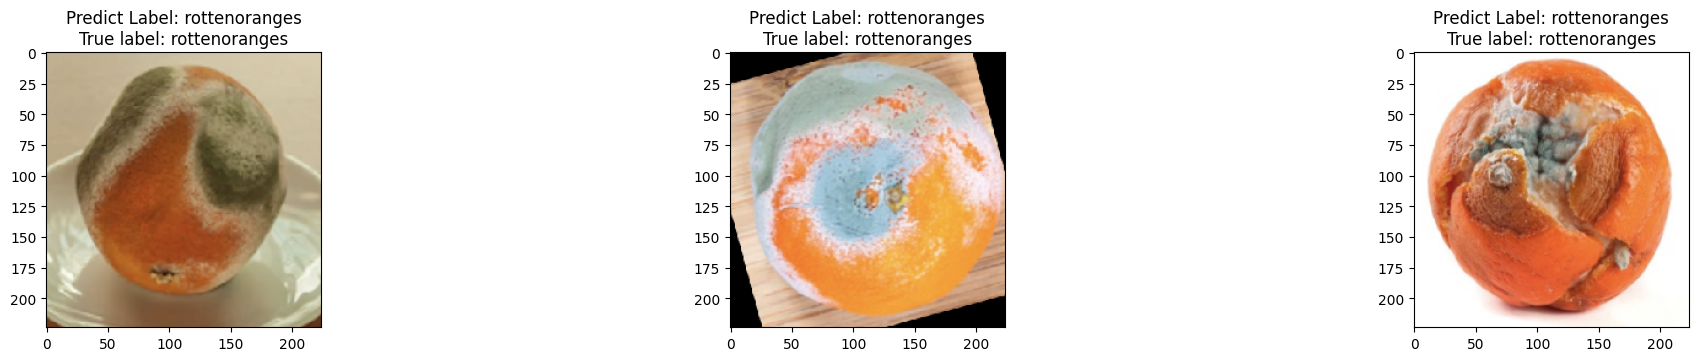

1/1 [==============================] - 0s 19ms/step


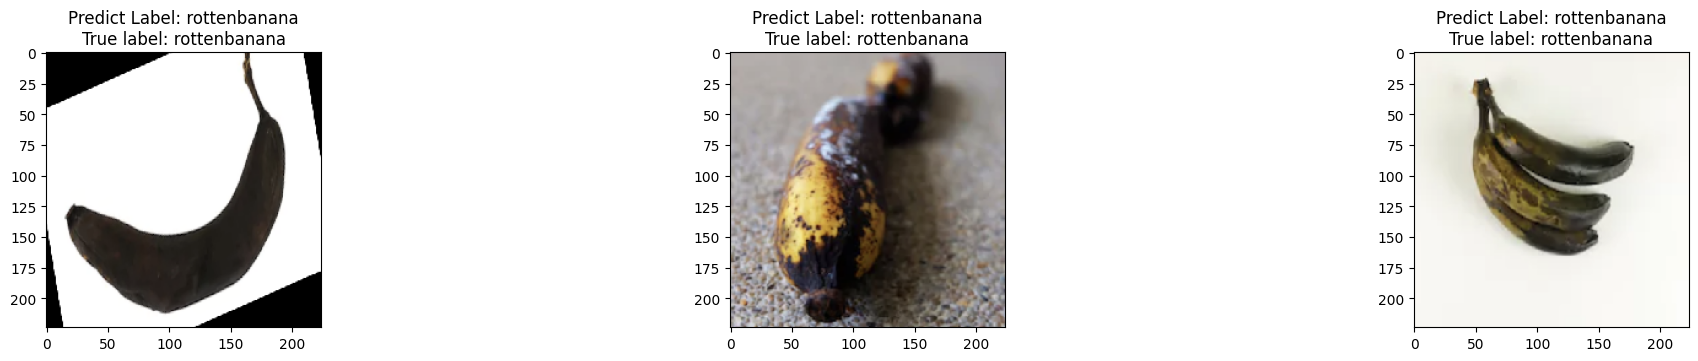

1/1 [==============================] - 0s 18ms/step


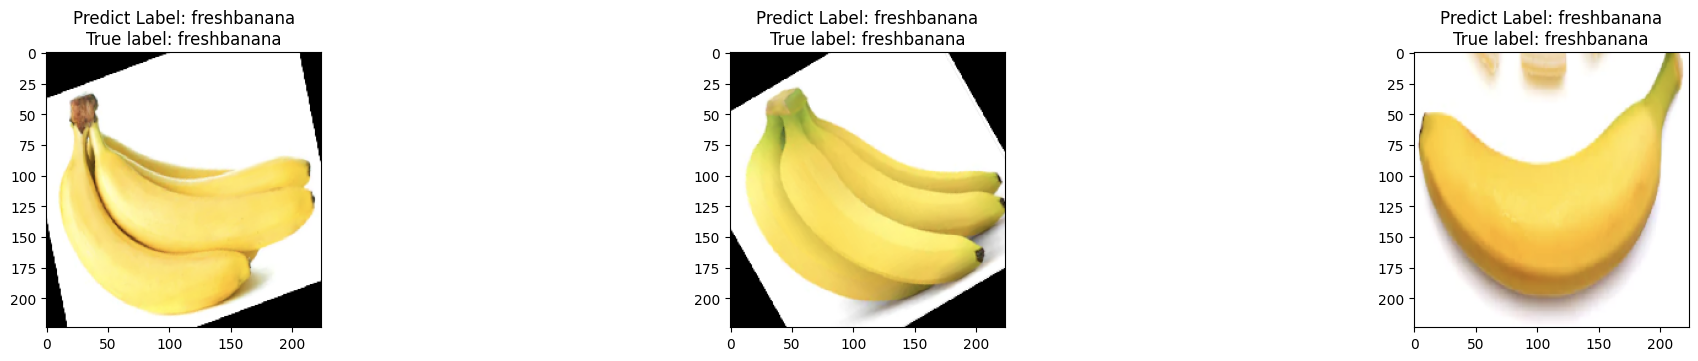

1/1 [==============================] - 0s 18ms/step


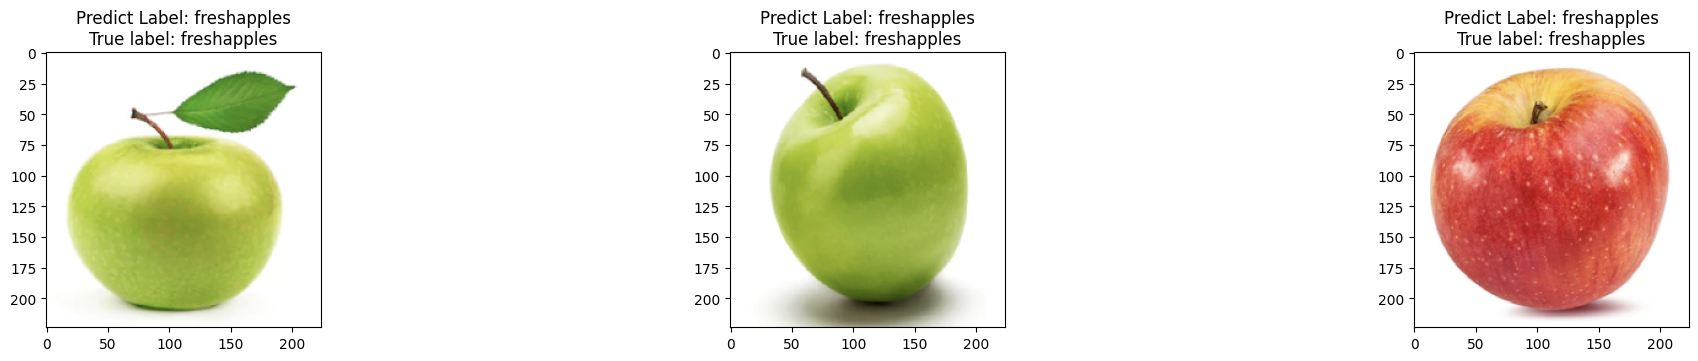

In [ ]:
test_path = "/content/gdrive/MyDrive/Fruit detection/Dataset/test/"
for class_name in os.listdir(test_path):
  T = os.listdir(test_path + '/' + class_name)[:3]
  fig = plt.figure(figsize=(25,25),dpi = 100)
  for x in range(len(T)):
    fig.add_subplot(6,3,x+1)
    img = load_img(test_path + class_name + '/' + T[x],target_size=(224,224,3))
    out = output(test_path + class_name + '/' + T[x])[0]
    percentage_list = []
    for i in range(len(out)):
      percentage_list.append(str(out[i]))
    S = ''
    compare_list = []
    for x in range(len(percentage_list)):
      compare_list.append([labels[x],float(percentage_list[x])])
    tmp = 0
    for i in compare_list:
      if(i[1] > tmp):
        tmp = i[1]
        tmp1 = i
    S = "Predict Label: " + tmp1[0] + '\nTrue label: ' + class_name
    plt.title(S)
    plt.imshow(img)
  plt.show()

1/1 [==============================] - 0s 19ms/step


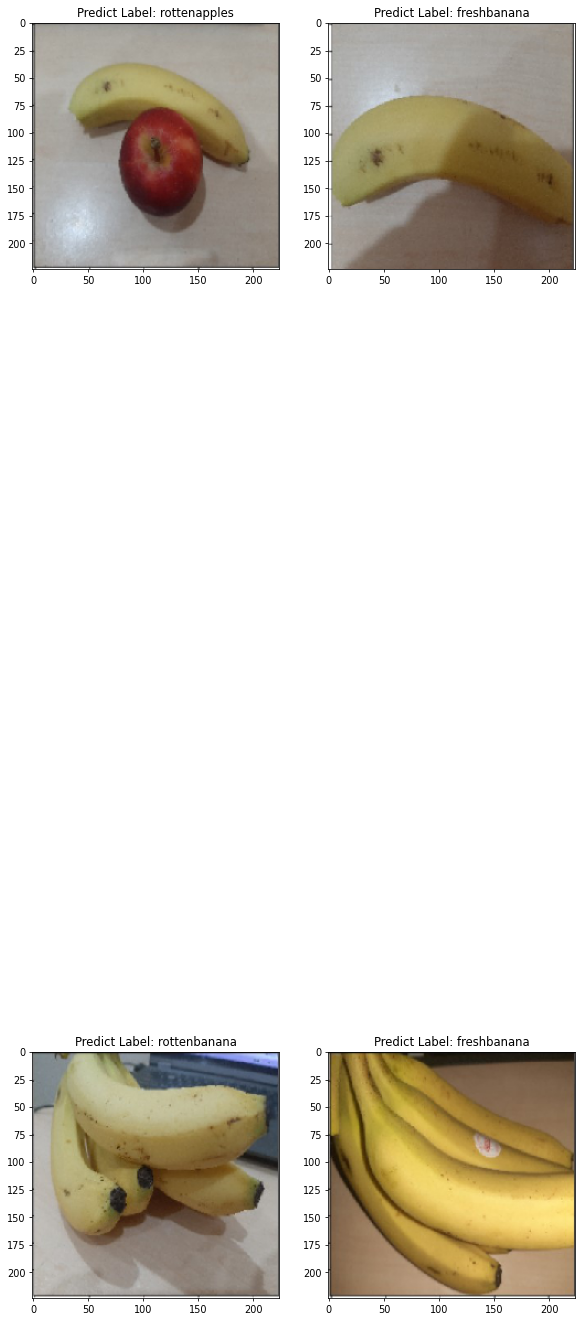

In [ ]:
test_other_path = "/content/gdrive/MyDrive/Fruit detection/Test/"
file = os.listdir(test_other_path)
fig = plt.figure(figsize=(10,35),dpi = 70)
for x in range(len(file)):
  fig.add_subplot(len(file)//2,2,x+1)
  img = load_img(test_other_path + file[x],target_size=(224,224,3))
  out = output(test_other_path + file[x])[0]
  percentage_list = []
  for i in range(len(out)):
    percentage_list.append(str(out[i]))
  S = ''
  compare_list = []
  for x in range(len(percentage_list)):
    compare_list.append([labels[x],float(percentage_list[x])])
    tmp = 0
    for i in compare_list:
      if(i[1] > tmp):
        tmp = i[1]
        tmp1 = i
  S = "Predict Label: " + tmp1[0]
  plt.title(S)
  plt.imshow(img)
plt.show()

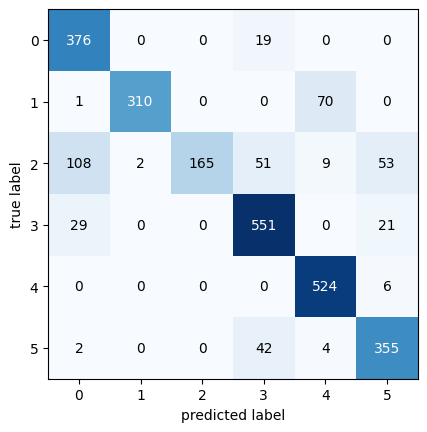

In [ ]:
y_true = [labels[x] for x in test_it.classes]
mat = confusion_matrix(y_true, pred1)
fig, ax = plot_confusion_matrix(mat)
plt.show()

In [ ]:
accuracy_score(y_true, prediction)

0.8454410674573758

In [ ]:
print(classification_report(y_true,prediction))

               precision    recall  f1-score   support

  freshapples       0.73      0.95      0.83       395
  freshbanana       0.99      0.81      0.89       381
 freshoranges       1.00      0.43      0.60       388
 rottenapples       0.83      0.92      0.87       601
 rottenbanana       0.86      0.99      0.92       530
rottenoranges       0.82      0.88      0.85       403

     accuracy                           0.85      2698
    macro avg       0.87      0.83      0.83      2698
 weighted avg       0.87      0.85      0.83      2698

